# Relax Inc. Data Science Challenge

The data has the following two tables:

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years.

2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

## 1. Data wrangling

Import packages and load dataset

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

user_file = 'data/takehome_users.csv'
usage_file = 'data/takehome_user_engagement.csv'

# Load datasets in pandas DataFrames
df_user = pd.read_csv(user_file, index_col='object_id', encoding="ISO-8859-1")
df_usage = pd.read_csv(usage_file, parse_dates=True, index_col='time_stamp')

Datasets inspection

In [2]:
# Inspect dfs size
df_user.shape, df_usage.shape

((12000, 9), (207917, 2))

In [3]:
# Inspect content
df_user.head(5)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# Inspect dataset
df_usage.head(5)

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


## 2. Target feature extraction

Firstly, we want to find which users signed-in at least once per day, so we will group the data by user and day

In [5]:
# Extract date from datetime index
df_usage['date'] = df_usage.index.date

# Group data by user and date
dfg = df_usage.groupby(by=['user_id', 'date']).sum()

In [6]:
# Inspect result of transformations
dfg.head()

visited
user_id date               
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1

Secondly, we will unstack the dataframe and transpose so we get each user in columns, and days as row indices.

In [7]:
# Unstack and transpose dataframe to have every user in a column
dfgu = dfg.unstack().T

In [8]:
# Inspect result
dfgu.head()

user_id             1      2      3      4      5      6      7      10     \
        date                                                                 
visited 2012-05-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
        2012-06-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
        2012-06-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
        2012-06-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
        2012-06-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

user_id             11     13     ...  11989  11990  11991  11992  11995  \
        date                      ...                                      
visited 2012-05-31    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
        2012-06-01    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
        2012-06-02    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
        2012-06-03    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
        2012-06-04    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   

user_id             11996  11997  11998  11999  12000  
        date                                           
visited 2012-05-31    NaN    NaN    NaN    NaN    NaN  
        2012-06-01    NaN    NaN    NaN    NaN    NaN  
        2012-06-02    NaN    NaN    NaN    1.0    NaN  
        2012-06-03    NaN    NaN    NaN    NaN    NaN  
        2012-06-04    NaN    NaN    NaN    NaN    NaN  

[5 rows x 8823 columns]

Thirdly, we will apply a rolling window to compute the number of logins in a seven day window by user

In [9]:
# Replace nan values for 0
dfgu.fillna(0, inplace=True)

# Drop first index level: it is not useful
dfgu.index = dfgu.index.droplevel(0)

# Reassign datetime data type to index
dfgu.index = pd.to_datetime(dfgu.index)

# Apply a rolling window of seven days adding the number of 
df2 = dfgu.rolling('7d', min_periods=3).sum().T

# Replace nan values for 0s
df2.fillna(0, inplace=True)

In [10]:
df2.sample(5)

date,2012-05-31,2012-06-01,2012-06-02,2012-06-03,2012-06-04,2012-06-05,2012-06-06,2012-06-07,2012-06-08,2012-06-09,...,2014-05-27,2014-05-28,2014-05-29,2014-05-30,2014-05-31,2014-06-01,2014-06-02,2014-06-03,2014-06-04,2014-06-06
user_id,,,,,,,,,,,,,,,,,,,,,
7198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0


Finally, we will create a new feature indicating whether the user is considered retained.

In [11]:
# Iterates through rows to check whether there are three logins in a 7 days window pero user.
for i, row in df2.iterrows():
    if (row >= 3).any():
        df2.loc[i, 'adopted_user'] = 1
    else:
        df2.loc[i, 'adopted_user'] = 0

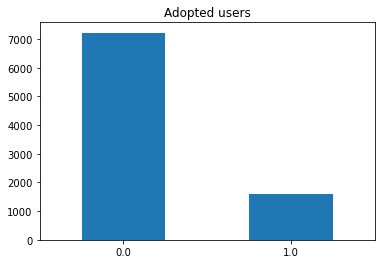

In [12]:
# Inspect values
df2['adopted_user'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Adopted users')
plt.show()

Merge target feature with other user's attributes from the first dataframe.

In [13]:
df = df_user.join(df2[['adopted_user']], how='left')

## 3. Data cleaning

We will clean the dataset by removing missing and inconsisten values. 

In [14]:
# Check for null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          6417 non-null   float64
 9   adopted_user                8823 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.3+ MB


In [15]:
# Nan values represent users who did not receive invitation from other user, so I will replace them with 0s 
df['invited_by_user_id'].fillna(0, inplace=True)

In [16]:
# Remove rows which do not contain information in 'retained_user'
df.dropna(axis=0, inplace=True)

In [17]:
# Check final result
df.shape

(8823, 10)

## 4. Feature Engineering

We will extract some meaningful features from existing attributes

In [18]:
# Extract user domain from email values
df['user_domain'] = df['email'].apply(lambda x: x[x.find('@')+1 : x.find('.')])

In [19]:
# Inspect result
df['user_domain'].value_counts().head(10)

gmail         2930
yahoo         1726
jourrapide     883
gustr          842
cuvox          828
hotmail        803
mumdc            2
oqpze            2
xybhi            2
xvnbr            2
Name: user_domain, dtype: int64

In [20]:
# Regroup and reduce categories
common_domains = df['user_domain'].value_counts()[:6].index.tolist()
df['user_domain'] = df['user_domain'].map(lambda x: 'other' if x not in common_domains else x)

In [21]:
# Extract period of day when the account was created
df['creation_time'] = pd.to_datetime(df['creation_time'])

def extract_period_of_day(x):
    """Extracts period of day from timestamp"""
    if (x.hour >= 8) & (x.hour < 12):
        return 'morning'
    elif (x.hour >= 12) & (x.hour < 17):
        return 'afternoon'
    elif (x.hour >= 17) & (x.hour < 22):
        return 'evening'
    else:
        return 'night'

df['creation_day_period'] = df['creation_time'].apply(lambda x: extract_period_of_day(x))

In [22]:
# Extract if the creation day was on a weekend or working day
df['creation_weekday'] = df['creation_time'].apply(lambda x: 0 if x.weekday()>4 else 1)

In [23]:
# Extract age of account
most_recent = max(df['creation_time'])
df['account_age'] = df['creation_time'].apply(lambda x: (most_recent - x).days)

In [24]:
# Regroup categories to a binary feature
df['invited_by_user'] = df['invited_by_user_id'].map(lambda x: 1 if (x != 0) else 0)

# Remove old feature
df.drop(['invited_by_user_id'], axis=1, inplace=True)

In [25]:
# Convert timestamp format 
df['last_session_creation_time'] = df['last_session_creation_time'].apply(lambda x: (datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

# Convert dtype to datetime
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'])

# Extract days since last login as new feature
most_recent = max(df['last_session_creation_time'])
df['days_since_last_login'] = df['last_session_creation_time'].apply(lambda x: (most_recent - x).days)

# Remove old feature
df.drop('last_session_creation_time', axis=1, inplace=True)

In [26]:
# Delete non useful columns
df.drop(['creation_time', 'name', 'email', 'org_id'], axis=1, inplace=True)

## 5. Exploratory Data Analysis

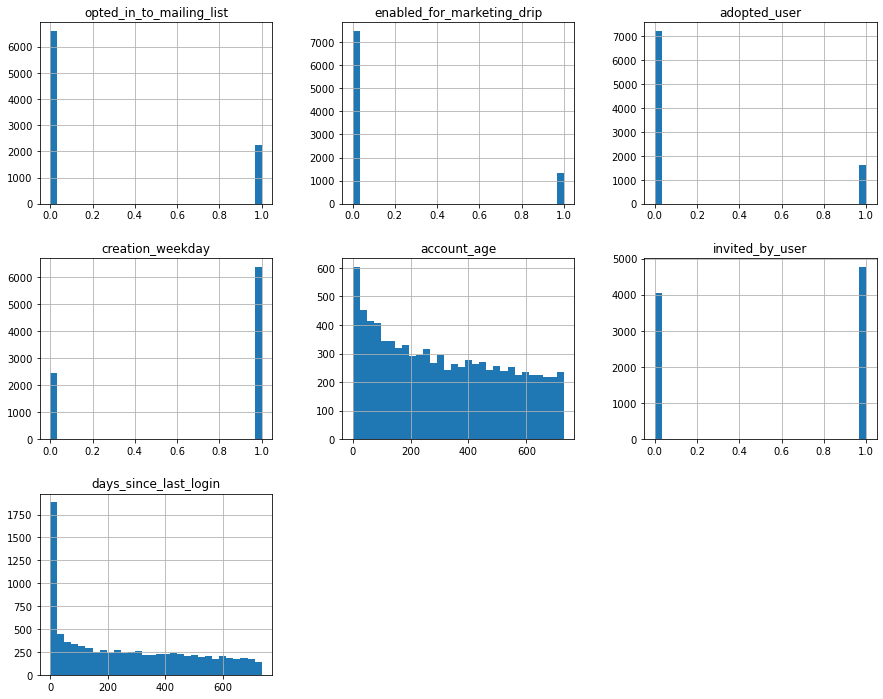

In [27]:
# Create histograms of all numerical features
df.hist(figsize=(15,12), bins=30)
plt.show()

In [28]:
def plot_categories(feature, data):
    '''Creates plot for categorical features with predefined layout'''
    plt.figure(figsize=(5,5))
    plt.title(feature.upper())
    plt.xticks(rotation=45)
    return sns.countplot(x=feature, data = data)

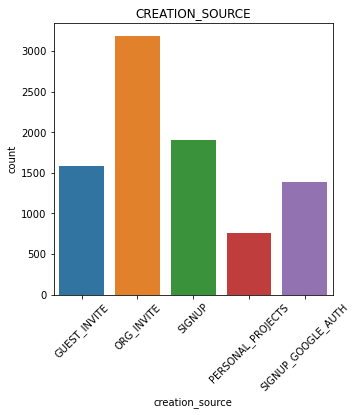

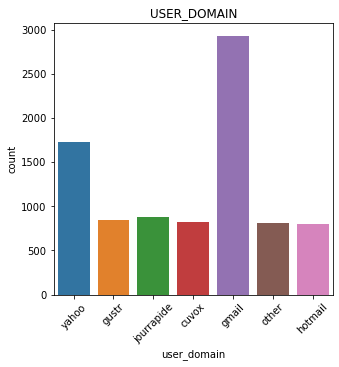

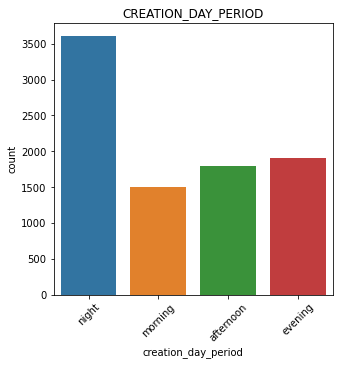

In [29]:
# Create plots for categorical features

plot_categories('creation_source', df)
plot_categories('user_domain', df)
plot_categories('creation_day_period', df)

plt.show()

In [30]:
# Convert categorical features to numerical independent variables
df = pd.get_dummies(df)

# Scale features to range [0,1]
mms = MinMaxScaler()
trans = mms.fit_transform(df)

# Convert result to dataframe for further inspection
dft = pd.DataFrame(trans, columns=df.columns)

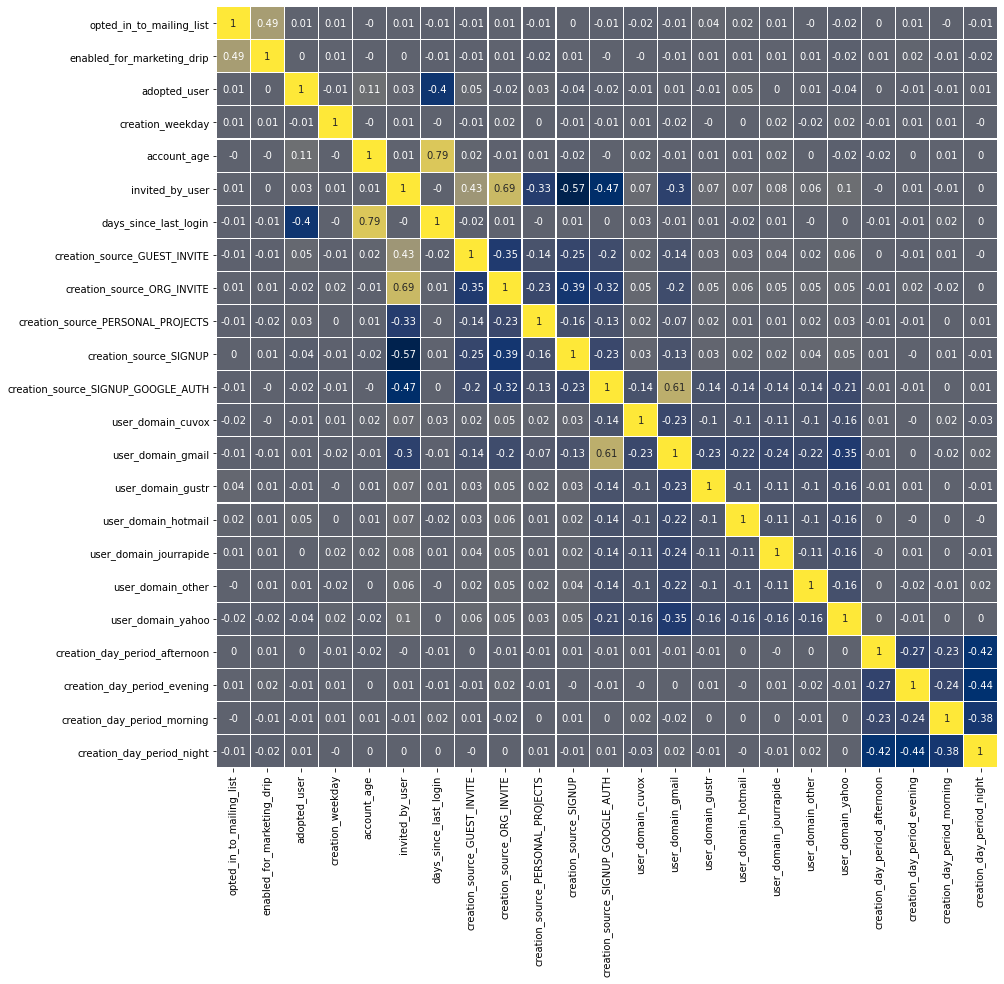

In [31]:
# Compute correlation matrix
df_corr = round(dft.corr(), 2)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(14,14))
sns.heatmap(df_corr, annot=True, cmap='cividis', linewidths=0.1, cbar=None)
plt.show()

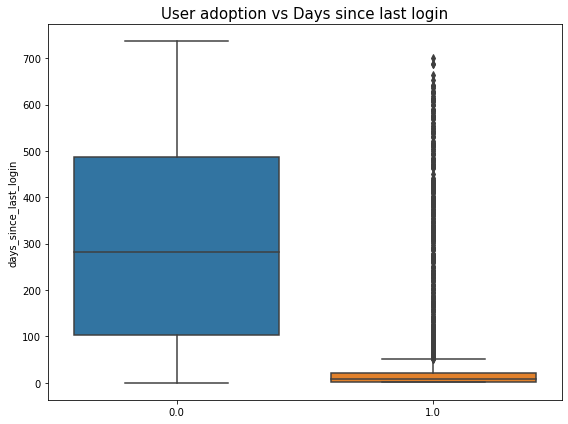

In [33]:
# Plot association between days_since_last_login and target variable: adopted user 
plt.figure(figsize=(8,6))
sns.boxplot(x ='adopted_user', y='days_since_last_login', data = df)
plt.title('User adoption vs Days since last login', fontsize=15)
plt.xlabel('')

plt.tight_layout()
plt.show()